In [13]:
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.ticker as plticker
from matplotlib.colors import LinearSegmentedColormap

### Given release and ambient conditions, a likely parcel-size distribution is built (on a log-normal assumption) and size-corresponding buoyant velocity is saved in a w_buoy.csv.


Input values:

- oil density
- nozzle diameter
- release vertical velocity
- dynamic viscosity
- number of numerical oil 'parcels' (not real oil particles)
- ambient water density
- interfacial oil-water tension


In [38]:
# Experimental parameters


rho_oil = 891  # oil density


D0 = 0.1  # nozzle diameter (cm)


V0 = 2  # release vertical velocity (m s^-1)


dyn_visc_oil = 0.0093479  # dynamic viscosity [N m^-2 s]


kin_visc_oil = dyn_visc_oil / rho_oil


N_particles = 2500  # number of parcels


rho_a = 1029.0  # water density (should depend on depth?)


interf_tens = 0.019  # Interfacial oil water tension (N/m)

In [39]:
# Empirical parameters

r = 14.05
p = 0.46
q = -0.518

In [40]:
# Maximum Characteristic Parcel Diameter d0

d_RT = (
    4 * (interf_tens / ((rho_a - rho_oil) * 9.81)) ** 0.5
)  # Rayleigh - Taylor instability maximum diameter (Li et al,. 2017; Grace et al., 1978)

d0 = min(d_RT, D0)  # minimum between nozzle diameter and d_RT
print("Rayleigh_Taylor diameter:", d_RT)
print("Characteristic MAX diameter:", d0)

Rayleigh_Taylor diameter: 0.014985206945152804
Characteristic MAX diameter: 0.014985206945152804


In [41]:
# Dimensionless characteristic numbers: Weber and Ohnesorge number


We = rho_a * V0**2 * d0 / interf_tens

Oh = dyn_visc_oil / ((rho_oil * interf_tens * d0) ** 0.5)

In [42]:
# Parcel Median Diameter


d50 = (r * (1 + 10 * Oh) ** p) * (We**q) * d0  # (m)


print("median diameter d50", d50)

median diameter d50 0.003455036763939032


In [43]:
Nbins = 100
delta = d0 / Nbins  # equal size ranges bewtween 0 and d0

d = np.zeros(Nbins)
bins = np.zeros(Nbins + 1)
f = np.zeros(Nbins)
f_abs = np.zeros(Nbins)
cum = np.zeros(Nbins)
w = np.zeros(Nbins)

ln_sigma = 0.5

In [ ]:
# Construct the diameters histogram

for j in range(0, Nbins):  # da 0 a 29

    d[j] = 0.5 * delta + j * delta  # diameter of bin j

    bins[j + 1] = delta + j * delta  # diameter of bin j

    f[j] = (
        1
        / ((2 * np.pi) ** 0.5 * ln_sigma * d[j])
        * np.exp(-((np.log(d[j]) - np.log(d50)) ** 2) / (2 * ln_sigma**2))
        * delta
    )


# Renormalization

sumf = np.sum(f)


print("sumf", sumf)


f_abs = np.around(f / sumf * N_particles).astype(
    int
)  # Number of particles for each of the Nbins droplet diameter ranges
print(f_abs)
sumf_abs = np.sum(f_abs)


print("tot particles before correction", sumf_abs)


# convert tot number to Nparticles


while sumf_abs < N_particles:

    rand_int = random.randint(0, Nbins - 1)

    f_abs[rand_int] += 1
    sumf_abs = np.sum(f_abs)


while sumf_abs > N_particles:

    rand_int = random.randint(0, Nbins - 1)

    f_abs[rand_int] -= 1
    sumf_abs = np.sum(f_abs)


print("tot particles after correction", sumf_abs)

sumf 0.9983296702047504
[ 0  0  0  0  2  6 12 21 32 44 55 66 76 83 90 94 97 98 98 97 95 92 89 85
 81 77 73 68 64 60 56 52 49 45 42 39 36 33 31 28 26 24 22 21 19 17 16 15
 14 13 12 11 10  9  8  8  7  7  6  6  5  5  4  4  4  3  3  3  3  3  2  2
  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  0  0  0  0]
tot particles before correction 2501
tot particles after correction 2500


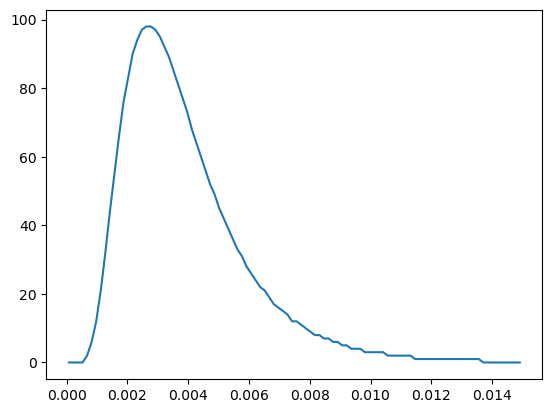

In [45]:
plt.plot(d, f_abs)

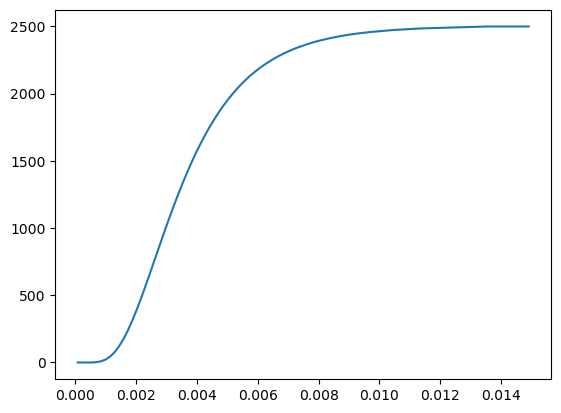

In [46]:
# Cumulative

for j in range(0, Nbins):
    for i in range(0, j + 1):
        cum[j] += f_abs[i]


plt.plot(d, cum)

C:\Users\Giulia\AppData\Local\Temp\ipykernel_15056\3476412378.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

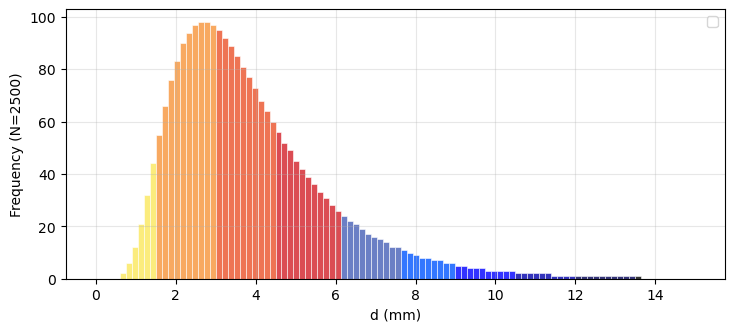

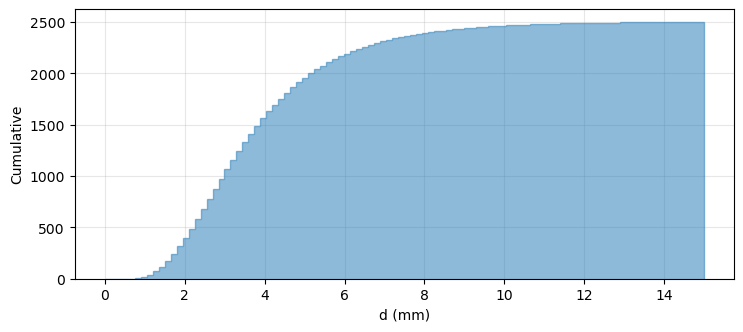

In [47]:
#  PLOTS

plt.clf()  # avoid overplot

# PLOT DISTRIBUTION
fig, ax = plt.subplots()
fig.set_size_inches(8.5, 3.5, forward=True)
plt.grid("both", alpha=0.3)

d1 = d * 1000  # (to mm)
bins1 = bins * 1000  # (to mm)
N, bins, patches = (
    ax.hist(  # N equals f_abs, the number of parcels in each bin, bins are bin edges, patches are rectangulars
        d1, bins=bins1, weights=f_abs, edgecolor="white", linewidth=0.5, alpha=0.8
    )
)


## Create the colormap
colors = [
    tuple(np.array((250, 232, 92)) / 255),  # yellow
    tuple(np.array((245, 106, 41)) / 255),  # orange
    tuple(np.array((211, 31, 40)) / 255),  # red
    # tuple(np.array((73,181,70))/255),   # green
    tuple(np.array((0, 127, 255)) / 255),  # blue
    tuple(np.array((0, 0, 255)) / 255),  # blue
    tuple(np.array((0, 0, 128)) / 255),  # blue
    tuple(np.array((0, 0, 0)) / 255),
]  # black


mycmap = LinearSegmentedColormap.from_list("WhiteBlueGreenYellowRed", colors, N=10)

for b, p in zip(bins1 / max(bins), patches):
    plt.setp(p, "facecolor", mycmap(b))


plt.xlabel("d (mm)", fontsize=10)
plt.ylabel("Frequency (N=" + str(N_particles) + ")", fontsize=10)
d1r = np.round(d1, 1)
# plt.xticks(d1r, fontsize=6 )
# plt.yticks(fontsize=8 )
# plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig("./size_distr_N" + str(N_particles) + ".png", bbox_inches="tight", dpi=300)


# PLOT CUMULATIVE

fig = plt.figure()
fig.set_size_inches(8.5, 3.5, forward=True)
plt.grid("both", alpha=0.3)
# plt.xscale('log')
plt.hist(d1, bins=bins1, weights=cum, histtype="step", fill=True, alpha=0.5)
# plt.xticks(d1, fontsize=4)
# plt.xscale('log')
plt.xlabel("d (mm)")
plt.ylabel("Cumulative")
# plt.show()
plt.savefig("./cumulative" + str(N_particles) + ".png", bbox_inches="tight", dpi=300)

In [48]:
# CALCULATE critical diameter

dc = (
    9.52
    * kin_visc_oil ** (2 / 3)
    * 9.81 ** (-1 / 3)
    * (1 - rho_oil / rho_a) ** (-1 / 3)
)
print("Critical diameter is {} mm".format(dc))

for i in range(0, Nbins):
    if d[i] < dc:
        w[i] = (9.81 * d[i] ** 2 * (1 - rho_oil / rho_a)) / (18 * kin_visc_oil)
    elif d[i] > dc:
        w[i] = (8 / 3 * 9.81 * d[i] * (1 - rho_oil / rho_a)) ** (1 / 2)

Critical diameter is 0.004163740082321075 mm


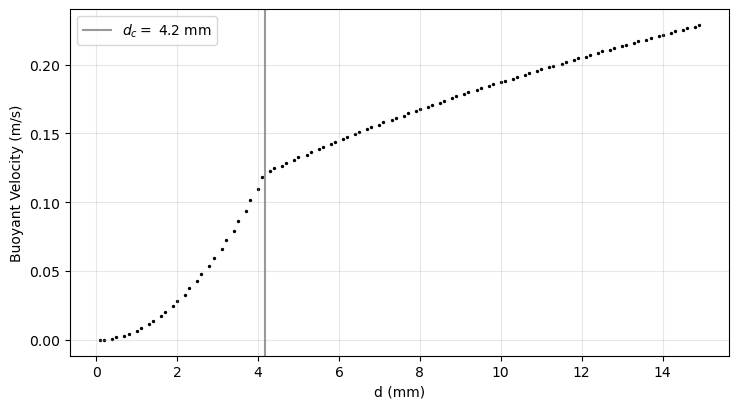

In [49]:
# PLOT VERTICAL BUOYANT VELOCITY


fig = plt.figure()

fig.set_size_inches(8.5, 4.5, forward=True)

plt.grid("both", alpha=0.3)

plt.axvline(
    x=dc * 1000,
    color="gray",
    linestyle="-",
    alpha=0.8,
    label=r"$d_c =$ " + str("%.1f" % (dc * 1000)) + " mm",
)

plt.scatter(d1r, w, color="black", s=2)

# plt.xscale('log')


plt.xlabel("d (mm)", fontsize=10)

# plt.xticks(d1r, fontsize=6 )

# plt.yticks(fontsize=8 )

# plt.xlim([0,15])

plt.ylabel("Buoyant Velocity (m/s)", fontsize=10)
plt.legend()

# plt.show()

plt.savefig("./buoyant_velocities.png", bbox_inches="tight", dpi=300)


# rint('size of fabs:', f_abs.size)

# print('size of w:', w.size)


data = {"Diam (mm)": d * 1000, "w_buoy (m/s)": -w, "Frequency": f}
datafile = pd.DataFrame(data)
datafile.to_csv("w_buoy.csv", index=False, sep="\t", float_format="%.4f")